In [50]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


# <center> IMPORTS AND DEF FUNCTIONS

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
from sklearn  import preprocessing, decomposition, base
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso, SGDClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve, KFold
from sklearn.model_selection import RandomizedSearchCV, cross_validate, ParameterGrid
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,VotingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import roc_curve, f1_score, precision_score, recall_score, auc, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.formula.api as sm
from sklearn.svm import SVC

import xgboost as xgb
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_importance
import time

import copy 
import pickle
from IPython.display import display
from matplotlib import interactive 
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
pd.options.display.max_columns = 40

from datetime import*
import time


#from utils import *

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']

""" IMPORTING MODEL
# serialize weights to HDF5
#history.save("history_base_25.h5")
from keras.models import load_model
 
# load model
model = load_model('model.h5')"""

os.chdir('./Colab_datasets/Final_versions')
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Colab_datasets/Final_versions'

In [0]:
from sklearn import datasets, linear_model
from keras import regularizers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

import copy
from keras.layers import *   #è incluso Flatten
from keras.models import *
from keras.layers import Concatenate, concatenate

#from Target_enc_class import *

In [0]:
class KFoldTargetEncoderTrain_std(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, colnames,targetName,n_fold=10,verbosity=True,discardOriginal_col=False, threshold= 1, showPrint= False):

        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
        self.threshold= threshold
        self.showPrint= showPrint

    def fit(self, X, y=None):
        return self

    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        assert(type(self.threshold) == int)
       
        kf = KFold(n_splits = self.n_fold, shuffle = False, random_state=2019)
        #kf = StratifiedKFold(n_splits = self.n_fold, shuffle = False, random_state=2019)

        col_mean_name = self.colnames + '_' + 'enc_mean'
        col_std_name= self.colnames + '_' + 'enc_std'
        
        #Le inizializzo con tutti NaN
        X[col_mean_name] = np.nan
        X[col_std_name] = np.nan
        
        #A ogni giro (per ogni K-Fold) fillo valori della Test Fold con la media delle Train Fold.
        for tr_ind, val_ind in kf.split(X):
            if self.showPrint is True:
                print('Indici delle Train-Folds: {},\033[1mTest Fold da fillare: {}\033[0m \n'.format(tr_ind, val_ind))  #sono gli indici delle folds

            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]

            diz_mean= X_tr.groupby(self.colnames)[self.targetName].mean().to_dict()
            diz_std= X_tr.groupby(self.colnames)[self.targetName].std().to_dict()

            #### Tratto come Nan chi non supera la threshold, agli altri assegno media e std sulle altre folds
            frequenze= X_tr.groupby(self.colnames).size()
            cat_oltre_threshold= frequenze[frequenze >= self.threshold].index
            
            if self.showPrint == True:
                print('cat_oltre_threshold', cat_oltre_threshold)

            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].apply(lambda x: diz_mean[x] if x in cat_oltre_threshold else np.nan )
            X.loc[X.index[val_ind], col_std_name] = X_val[self.colnames].apply(lambda x: diz_std[x] if x in cat_oltre_threshold else np.nan)

            mean_of_target = X_tr[self.targetName].mean()  #media di tutto il target sul KFold Train, not grouped
            std_of_target= X_tr[self.targetName].std()    # # std di tutto il target sul KFold Train, not grouped

            X[col_mean_name].fillna(mean_of_target, inplace = True) #ai NaN metto la media del KFold Train Target
            X[col_std_name].fillna(std_of_target, inplace = True)   # ai NaN metto la std dev media del Kfold Train Target

        if self.verbosity:

            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,
                                    self.targetName,np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
            
        if self.discardOriginal_col:
            if self.showPrint == True:
                print('columns: ', X.columns)
            X = X.drop(self.colnames, axis=1)
        return X
    
    
class KFoldTargetEncoderTest_std(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self,train,colNames,Train_encoded_mean, Train_encoded_std, showPrint= False):
        
        self.train = train
        self.colNames = colNames
        self.Train_encoded_mean = Train_encoded_mean
        self.Train_encoded_std = Train_encoded_std
        self.showPrint= showPrint
        
    def fit(self, X, y=None):
        return self

    def transform(self,X):

        ### Media e std del Target grouped per categoria su tutto il Train
        category_mean_tr = self.train[[self.colNames,self.Train_encoded_mean]].groupby(self.colNames).mean() #.reset_index() 
        category_std_tr= self.train[[self.colNames,self.Train_encoded_std]].groupby(self.colNames).mean() #.reset_index() 
        
        ### Media dell'Encoding basato su mean e std sul Train (non grouped per categoria)
        population_mean_tr= self.train[self.Train_encoded_mean].mean()
        population_std_tr= self.train[self.Train_encoded_std].mean()
        
        ### Metto nel Test i valori medi della mean e std del Train per quella categoria
        X[self.Train_encoded_mean]= X[self.colNames].map(category_mean_tr.squeeze().to_dict())
        X[self.Train_encoded_std]= X[self.colNames].map(category_std_tr.squeeze().to_dict())
        
        ### Fillo i Missing Values (Categorie Nuove) con i valori medi di mean e std (encodate) di tutte la variabile nel Train
        if self.showPrint== True:
            print('Filled {} Missing Values with Average mean and std equals to {}, {}'.format(
                                                        np.sum(np.sum(X.isna())), population_mean_tr , population_std_tr))
        
        X[self.Train_encoded_mean].fillna(population_mean_tr, inplace = True) #fillo con media di enc_mean sul Train
        X[self.Train_encoded_std].fillna(population_std_tr, inplace = True)   #fillo con media di enc_std sul Train
        
        return X

In [0]:
def MAPE(y_true, y_pred):   #
    """mean_absolute_percentage_error. Nel mio caso non ha senso, sono gia tutte percentuali. Se divido per y_true, 
    #ho quasi divisione per 0 a volte...perciò meglio MAE, che essendo su valori % funge praticamente da MAPE"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    #return np.mean(np.abs((y_true - y_pred) / y_true))  * 100
    return np.mean(np.abs((y_true - y_pred)/ y_true))*100

def container_modello(task):
    """Return un diz con chiavi X_train, X_test, y_train, y_test, best_estimator
    caso: 'classo', 'rollingreg', 'rollingreg' """
    
    if task== 'class':
        X_train= container_class['X_train']
        X_test= container_class['X_test']
        y_train= container_class['ytrain']
        y_test= container_class['ytest']
        #best_est= best_class_rf
        #feat_imp= feats_imp_class
        
    elif task== 'reg':
        X_train= container_reg['X_train']
        X_test= container_reg['X_test']
        y_train= container_reg['ytrain']
        y_test= container_reg['ytest']
        #best_est= best_reg_rf
        #feat_imp= feats_imp_rfreg
        
    return {'X_train': X_train, 'X_test': X_test, 'ytrain': y_train, 'ytest': y_test}

def summary_reg_grid(grid_fit, scaled_train, Y_train, scaled_test, Y_test):
    """current_minimize è inutile"""
    print('best param combination: ', grid_fit.best_params_)   #'C': 0.357
    
    #print('\n\033[1mtrain MAE is {} \033[0m'.format(round(mean_absolute_error(Y_train, grid_fit.predict(scaled_train)),4)))
    #print('\033[1mtest MAE is {} \033[0m'.format(round(mean_absolute_error(Y_test, grid_fit.predict(scaled_test)),4)))
    
    idx_max_val_score= np.argmax(grid_fit.cv_results_['mean_test_score'])
    
    # Siccome MAE è molto piu lento da minimizzare, quando algoritmi vanno lenti mi conviene minimizzare MSE e 
    # calcolare MAE a mano in corrispondenza del modello migliore trovato minimizzando MSE.
    
    print('\n\033[1mTrain MAE is {} \033[0m'.format(round(-1* grid_fit.cv_results_['mean_train_score'][idx_max_val_score],4)))
    # Validation score controllato manualmente è sempre uguale a quello dato da grid.best_score_
    #print("\n\033[1m 'MANUAL' Validation MAE \033[0m is {}):".format(round(-1*max(grid_fit.cv_results_['mean_test_score']) ,4)))
    print("\033[1mValidation MAE \033[0m (best mean CV score) is \033[1m {} \033[0m".format(round(-1*grid_fit.best_score_ ,4))) #Mean cross-validated score of the best_estimator
    
    #elif current_minimize == 'mse':
        #print('..Calculating MAE by hand for the best model on the whole Train and Test set..')
        #print('\n\033[1mTrain MAE is {} \033[0m'.format(round(mean_absolute_error(Y_train, grid_fit.predict(scaled_train)),4)))
    
    print('\033[1mTest MAE is {} \033[0m'.format(round(mean_absolute_error(Y_test, grid_fit.predict(scaled_test)),4)))
    
    print('\n\033[1mtrain RMSE is {} \033[0m'.format(round(np.sqrt(mean_squared_error(Y_train, grid_fit.predict(scaled_train))),4)))
    print('\033[1mtest RMSE is {} \033[0m'.format(round(np.sqrt(mean_squared_error(Y_test, grid_fit.predict(scaled_test))),4)))

    print('\n\033[1mtrain MAPE is {} \033[0m'.format(round(MAPE(Y_train, grid_fit.predict(scaled_train))),4))
    print('\033[1mtest MAPE is {} \033[0m'.format(round(MAPE(Y_test, grid_fit.predict(scaled_test)),4)))

def df_cv_results(grid_fit, n_to_show= 5):
    df= pd.DataFrame(grid_fit.cv_results_)
    df= df[[col for col in df.columns if 'param_' in col]+['mean_test_score', 'mean_train_score']]
    return df.sort_values(by= 'mean_test_score', ascending= False).head(n_to_show)

def plot_preds_true(ytrue, ypred, single_model= True, plot_only_reg= True, n_to_show= 1000, diz_models= None, n_cols= 2, task= ''):
  """diz_models deve essere dizionario con modello: nome_modello"""
  index= np.arange(len(container_double['X_test']))
  ypred= pd.DataFrame(ypred,  ).set_index(index).squeeze()
  ytrue= pd.DataFrame(ytrue, ).set_index(index).squeeze()

  if single_model is True:
    if plot_only_reg is True:
      title_ticks_ecc('Preds VS True %' + task.upper(), 'True', 'Pred')
      plt.scatter(ytrue, ypred, label= 'True', c= np.random.choice(colors))

    else:
      plt.figure(figsize= (15, 5), )
      plt.subplot(1, 2, 1 )
      plt.title('Preds VS True %' + task.upper(), fontsize= 12, color= 'red')
      plt.plot(ytrue[:n_to_show], color='c', label= 'True')
      plt.plot(ypred[:n_to_show], color='orange', label= 'Pred')
      plt.legend(fontsize= 15)

      plt.subplot(1, 2, 2 )
      plt.title('Preds VS True\n(Ideale è Bisettrice) %' + task.upper(), fontsize= 12, color= 'red')
      plt.scatter(ytrue, ypred, label= 'True', c= np.random.choice(colors))
      plt.ylabel('Pred', fontsize= 12, color= 'red')
      plt.xlabel('True', fontsize= 12, color= 'red')
      plt.legend()
      plt.tight_layout()

  elif single_model is False:
    rows_for_n_cols= np.ceil(len(diz_models)/n_cols)
    plt.figure(figsize= (15, 10))
    for i, est in enumerate(diz_models):
      ypred= pd.Series(est.predict(container_double['X_test']), index= np.arange(len(container_double['ytest'])))
      plt.subplot(rows_for_n_cols, n_cols, i+1)
      plt.title('Preds VS True {}'.format(diz_models[est]), fontsize= 12, color= 'red')
      plt.scatter(ytrue, ypred, label= 'True', c= np.random.choice(colors))
      plt.ylabel('Pred', fontsize= 12, color= 'red')
      plt.legend()
      plt.tight_layout()

In [0]:
def df_cv_results(grid_fit, n_to_show= 5):
    df= pd.DataFrame(grid_fit.cv_results_)
    df= df[[col for col in df.columns if 'param_' in col]+['mean_test_score', 'mean_train_score']]
    return df.sort_values(by= 'mean_test_score', ascending= False).head(n_to_show)

def after_nn(grid, show_df= False, n_to_show= 5):
  print('best_score and best params:', grid.best_score_, grid.best_params_)
  results= df_cv_results(grid)
  return results.head(n_to_show)

def title_ticks_ecc(title, xlabel, ylabel, new_fig= True , figsize= (10,6)):
    if new_fig== True:
        plt.figure(figsize=figsize)
        
    plt.title(title, color='red', fontsize= 18, pad= 13)
    plt.xlabel(xlabel, color='red', fontsize= 14)
    plt.ylabel(ylabel, color='red', fontsize= 14)
    plt.xticks(fontsize=12, color='blue')
    plt.yticks(fontsize=12, color='blue')

def plot_model_history(history, measures = ["mean_absolute_error", "mean_absolute_percentage_error", "loss"]):

  plt.style.use("ggplot")
  (fig, ax) = plt.subplots(1, 3, figsize=(20, 5))

  # loop over the accuracy names
  for (i, l) in enumerate(measures):
    # plot the loss for both the training and validation data
    ax[i].set_xlabel("Epoch #")
    if l!= 'loss':
      ax[i].set_title("{}".format(l ))
      ax[i].set_ylabel("{}".format(l))
    else:
      ax[i].set_title("Loss")
      ax[i].set_ylabel("Loss")
    #ax[i].plot(np.arange(0, epochs), history.history[l], label=l)
    #ax[i].plot(np.arange(0, epochs), history.history["val_" + l], label="val_" + l)
    ax[i].plot(history.history[l], label=l)
    ax[i].plot( history.history["val_" + l], label="val_" + l)
    ax[i].legend()

  plt.tight_layout() 
  plt.show()
  plt.close()

In [0]:
class Customized_Label_Encoder(object):
    def fit_pd(self,df,cols=[]):
        '''
        fit all columns in the df or specific list. 
        generate a dict:
        {feature1:{label1:1,label2:2}, feature2:{label1:1,label2:2}...}
        '''
        if len(cols) == 0:
            cols = df.columns
        self.class_index = {}
        for f in cols:
            uf = df[f].unique()
            self.class_index[f] = {}
            index = 1
            for item in uf:
                self.class_index[f][item] = index
                index += 1
    
    def fit_transform_pd(self,df,cols=[]):
        '''
        fit all columns in the df or specific list and return an update dataframe.
        '''
        if len(cols) == 0:
            cols = df.columns
        newdf = copy.deepcopy(df)
        self.class_index = {}
        for f in cols:
            uf = df[f].unique()
            self.class_index[f] = {}
            index = 1
            for item in uf:
                self.class_index[f][item] = index
                index += 1
                
            newdf[f] = df[f].apply(lambda d: self.update_label(f,d))
        return newdf
    
    def transform_pd(self,df,cols=[]):
        '''
        transform all columns in the df or specific list from lable to index, return an update dataframe.
        '''
        newdf = copy.deepcopy(df)
        if len(cols) == 0:
            cols = df.columns
        for f in cols:
            if f in self.class_index:
                newdf[f] = df[f].apply(lambda d: self.update_label(f,d))
        return newdf
                
    def update_label(self,f,x):
        '''
        update the label to index, if not found in the dict, add and update the dict.
        '''
        try:
            return self.class_index[f][x]
        except:
            self.class_index[f][x] = max(self.class_index[f].values())+1
            return self.class_index[f][x]

**<center> Imports**

In [61]:
pwd

'/content/drive/My Drive/Colab Notebooks/Colab_datasets/Final_versions'

In [62]:
REMOVE_N_ORDERS= True

X_train= pd.read_pickle('./double/X_train_emb_double.pk1') #.set_index('Purchase document')  #.drop('supplier_class', axis=1)
X_test= pd.read_pickle('./double/X_test_emb_double.pk1')  #.set_index('Purchase document')    #.drop('supplier_class', axis=1)

with open('./double/targets.pickle', 'rb') as targ:
    targets=  pickle.load(targ)

targets.keys()

print(X_train.shape, X_test.shape)  #(232298, 29) (41158, 29)

X_train.sample(2)

(259053, 39) (45511, 39)


,Purchase document,Global Business line,Purchase document type,Job type,Variant code,Global Purchase Unit Code,Contract Type,Header amount,QMG Code,VMD Code,Main material group qualification flag,Supplier Type Code,Geographical Area,Country Code,Purchase Unit Code,Purchase Country Code,Professional services flag,num_orders,%avg_importo,%std_importo,%avg_intervals,%std_intervals,life%,%days_til_first_order,durata_nominale_gg,percentage_used,ordini/mese,label,target_class,True/Ideal Slope,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used,%days_from_last_order,Target%
10467,SZ\8400056553,GIT,V,F,1,GIT,0,766764.00,SPPI26,6469,0,S,Nord,IT,ITP,IT,1,5,16.562,8.22,11.064,5.319,70.0,11.229,846,82.81,0.25,1,99.99,118.34,0.125,0.75,0.0,0.125,4,0.0,0.0,20.946,84.99
451062,EL\5100010460,GIN,Z,F,1,BRA,0,26181.46,FESO17,181167,1,S,Estero,BR,BRI,BR,0,0,0.000,0.00,20.219,0.000,20.0,20.219,183,0.00,0.00,0,0.00,0.00,0.000,0.00,0.0,0.000,1,0.0,0.0,-1.000,100.00


In [0]:
for task in ['class', 'reg']:
  for i in [0,1]:
    targets[task][i]= MinMaxScaler().fit_transform(np.array(targets[task][i]).reshape(-1,1))

ytrain_usage= pd.DataFrame(targets['class'][0], index= X_train['Purchase document']).squeeze()
ytest_usage= pd.DataFrame(targets['class'][1], index= X_test['Purchase document']).squeeze()

ytrain_life= pd.DataFrame(targets['reg'][0], index= X_train['Purchase document']).squeeze()
ytest_life= pd.DataFrame(targets['reg'][1], index= X_test['Purchase document']).squeeze()

In [64]:
X_train[X_train['label']== 0]['Target%'].value_counts() #Giusto, quando non lo uso, Target% è sempre 1

100.0    182727
Name: Target%, dtype: int64

In [0]:
not_used_train= X_train.loc[X_train['label']== 0]['Purchase document']
not_used_test= X_test.loc[X_test['label']== 0]['Purchase document']

used_train= X_train.loc[X_train['label']== 1]['Purchase document']
used_test= X_test.loc[X_test['label']== 1]['Purchase document']

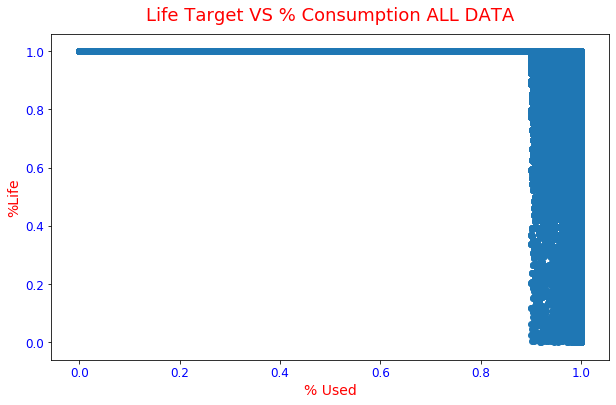

In [66]:
title_ticks_ecc('Life Target VS % Consumption ALL DATA', '% Used', '%Life')
plt.scatter(ytrain_usage, ytrain_life)  #Interpetazione: per %utilizzo= 0, 

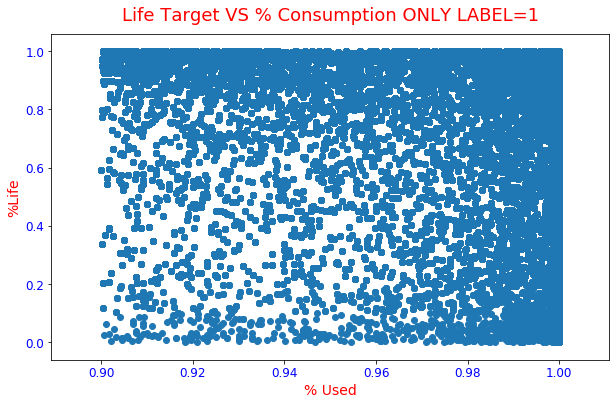

In [67]:
title_ticks_ecc('Life Target VS % Consumption ONLY LABEL=1', '% Used', '%Life')
plt.scatter(ytrain_usage.loc[used_train], ytrain_life.loc[used_train])  #Interpetazione: per %utilizzo= 0, 

In [0]:
X_train['target_class']= X_train['target_class']/100
X_train['Target%']= X_train['Target%']/100

# <center> Preprocessing

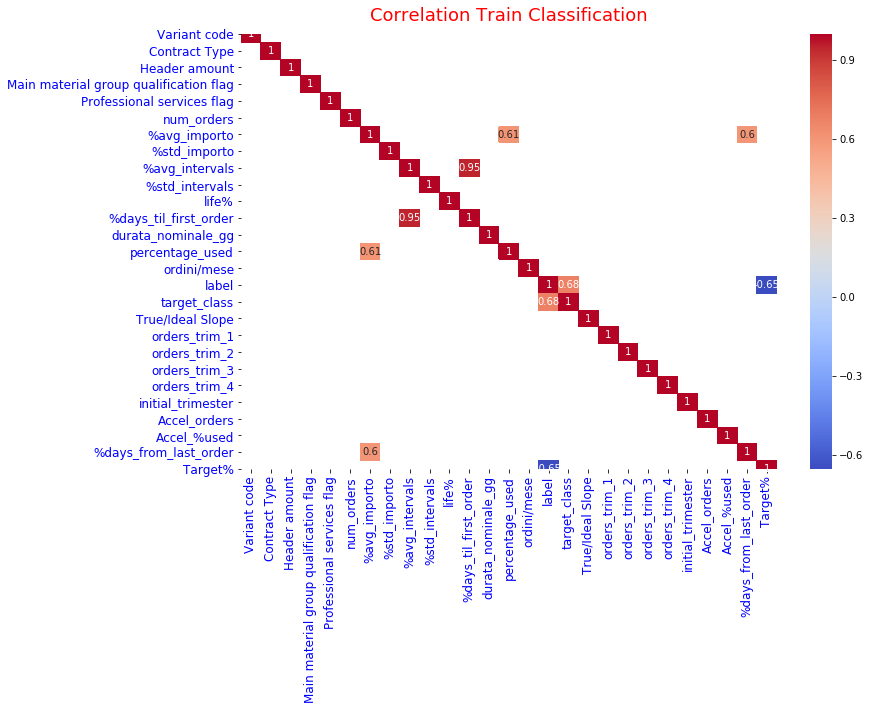

In [69]:
soglia = 0.6

title_ticks_ecc('Correlation Train Classification', '', '', figsize=(12, 8))
sns.heatmap(X_train.corr()[abs(X_train.corr())> soglia ], cmap= 'coolwarm', annot= True,)

In [0]:
corr_feats_to_cut= ['Purchase Country Code', 'Country Code', 'Global Purchase Unit Code',]

In [71]:
cardinalita={}
for col in X_train.drop('Purchase document', axis=1, errors= 'ignore').select_dtypes(include=[object]).columns:
    cardinalita[col]= X_train[col].nunique()
cardinalita= pd.Series(cardinalita)
cardinalita= cardinalita.sort_values(ascending=False)
#d= d.drop('life%')
cardinalita= pd.DataFrame(cardinalita, columns= ['cardinalità_classe'])
cardinalita

,cardinalità_classe
VMD Code,11194
QMG Code,862
Purchase Unit Code,76
Country Code,59
Purchase Country Code,13
Global Purchase Unit Code,13
Global Business line,8
Geographical Area,5
Supplier Type Code,5
Purchase document type,4


#### **Custom Target Encoding for categorical variables with highest cardinality**

In [0]:
#@title
def encoding_cat_noise(xtrain_orig, xtest_orig, task='class', label='target_class', verbose= False, minimum_std= 0.1, n_folds=200, 
                              prop_std_per_noise= 0.05, threshold= 10, showPrint= False, cols_to_encode= None, suffix= '_FINAL_ENC'):
    
    """return diz={'scaled_train': scaled_train, 'scaled_test': scaled_test, 'ytrain': ytrain, 'ytest': ytest}
       task= ['class', 'reg']"""
    
    np.random.seed(42)
    xtrain= xtrain_orig.copy()
    xtest= xtest_orig.copy()
    
    if task == 'reg':
        label= 'Target%'
        # solo per Regressione, divido Target per 100
        ytrain= xtrain[label]  #.apply(lambda x: round(x/100, 4))
        ytest=  xtest[label]   #.apply(lambda x: round(x/100, 4))
    
    else:  #task== 'class'
        ytrain= xtrain[label]
        ytest= xtest[label]
    
    print('Train and Test initial shapes (including target): ', xtrain.shape, xtest.shape)
    print('Threshold is: ', threshold)
    #purch_doc_train= xtrain['Purchase document']
    #purch_doc_test= xtest['Purchase document']
    #xtrain= xtrain.drop('Purchase document', axis=1)
    #xtest= xtest.drop('Purchase document', axis=1)
    
    
    #Faccio Encoding di tutte quelle di tipo Oggetto, cioè stringe
    cardinalita_Xtrain={}
    for col in xtrain.drop('Purchase document', axis=1).select_dtypes(include=[object]).columns:
        cardinalita_Xtrain[col]= xtrain[col].nunique()
    cardinalita_Xtrain= pd.Series(cardinalita_Xtrain)
    cardinalita_Xtrain= cardinalita_Xtrain.sort_values(ascending=False)
    cardinalita_Xtrain= pd.DataFrame(cardinalita_Xtrain, columns= ['cardinalità_classe'])
    cardinalita_Xtrain

    columns_to_encode= list(cardinalita_Xtrain.index)
    if cols_to_encode is not None:  #le cambio solo se glielo specifico, sennò lo faccio per tutti i dtypes= object
      columns_to_encode= cols_to_encode
    
    print('...Performing Encoding...')
    for col in columns_to_encode:
        #if showPrint== True:
            #print('\n COLUMN NAME: ', col)  VMD Code_enc_mean
        targetc = KFoldTargetEncoderTrain_std(col, label ,n_fold= n_folds, verbosity= verbose,threshold = threshold, showPrint= showPrint)
        xtrain = targetc.fit_transform(xtrain)
        #print(xtrain.iloc[:2, 17:], '\n')

        test_targetc = KFoldTargetEncoderTest_std(xtrain,col, col+ '_enc_mean', col+ '_enc_std')
        xtest= test_targetc.fit_transform(xtest)
        
        xtrain= xtrain.drop(col, axis=1)
        xtest= xtest.drop(col, axis=1)
    print('...Encoding Terminated...')
        
    xtrain= xtrain.drop( [label], axis=1)
    xtest= xtest.drop([label], axis=1)
             
    #### Metto minimum_std dev a chi ha 0, così poi ci sarà un po' di Noise pure in corrispondenza di quei samples
    cols_std= [col for col in xtrain.columns if col.split('_')[-1]== 'std']
    
    for col in cols_std:
        xtrain[col]= xtrain[col].apply(lambda x: minimum_std if x==0 else x)
        xtest[col]= xtest[col].apply(lambda x: minimum_std if x==0 else x)
        
    #for col in cols_std:
        #print('Ci sono {} std = 0 per colonna {}'.format(xtrain[col][xtrain[col]== 0].sum(), col))
    
    ###### Final Encoding con Noise #########
    cols_mean= [col for col in xtrain.columns if col.split('_')[-1]== 'mean']
    diz_mean_std= dict(zip(cols_mean, [col[: len(col)- len('mean')] +'std' for col in cols_mean] ))
    
    for key in diz_mean_std.keys():  #key è la colonna con la media
        if showPrint== True:
            print(' key and value are: ', key, diz_mean_std[key] ) 
        for X in [xtrain, xtest]:   # Creo colonna con encoding finale e droppo le due di mean e std encoding
            ### Metto Noise sono nel Training. Nel test solo medie.
            if X is xtrain:   
                X[key[: - len('_enc_mean')] + suffix ] = np.random.normal(X[key], prop_std_per_noise* X[diz_mean_std[key]], len(X))
            elif X is xtest:
                X[key[: - len('_enc_mean')] + suffix ]= X[key]  #key è la colonna con la media
            X.drop([key, diz_mean_std[key]], axis=1, inplace= True)
                
    ##### Faccio dei Check #####
    if len(xtrain.select_dtypes(include=object).columns) ==1 and len(xtest.select_dtypes(include=object).columns) ==1:
        print('\n \033[1mCORRETTO: Tutte colonne sono numeriche, a parte Purchase Doc!!\033[0m')
    else:
        print('\n \033[1mSBAGLIATO: n° colonne non numeriche non è 1 (Purchase Doc), ma ', max(len(xtrain.select_dtypes(include=object).columns),  
                                                                                   len(xtest.select_dtypes(include=object).columns)))
        
        
    ### Ultimo check: colonne Train e Test devono essere uguali
    if list(xtrain.columns) != list(xtest.columns): 
        print('ERRORE: COLONNE IN TRAIN E TEST SONO DIVERSE')
        
    #Gli rimetto Purchase Document, solo per andare in Join dopo
    #xtrain.insert (0, "Purchase document", purch_doc_train)
    #xtest.insert(0, "Purchase document", purch_doc_test)
    #numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    time_init= time.time()
    for x in [xtrain, xtest]:
        if x.index.name != 'Purchase document':
          x.set_index('Purchase document', inplace= True)
        for col in x.select_dtypes(include= 'float64'):  #include='numerics'
            x[col]= x[col].apply(lambda x: round(x, 4))
    print('execution time (min) for rounding=', round((time.time()-time_init)/60, 1))
        
    print('\n Train and Test final shapes: ', xtrain.shape, xtest.shape)
        
    return {'X_train': xtrain, 'X_test': xtest, 'ytrain': ytrain, 'ytest': ytest}

In [79]:
##################################### Encdoding iin respect to Consumption Target #######################################
cols_to_encode= ['VMD Code', 'QMG Code']

thresh_class= 30
#Final shapes: (130240, 29) (23001, 29)
container_class= encoding_cat_noise( X_train, X_test, label= 'target_class', n_folds= 200, minimum_std= 0.1, 
                                    prop_std_per_noise= 0.05, threshold= thresh_class, showPrint= False, cols_to_encode= cols_to_encode)

Train and Test initial shapes (including target):  (259053, 39) (45511, 39)
Threshold is:  30
...Performing Encoding...
...Encoding Terminated...

 SBAGLIATO: n° colonne non numeriche non è 1 (Purchase Doc), ma  10
execution time (min) for rounding= 0.1

 Train and Test final shapes:  (259053, 37) (45511, 37)


In [80]:
################################ Encdoding iin respect to Lifetime Target #######################################
cols_to_encode= ['VMD Code', 'QMG Code']

#Final shapes: (130240, 29) (23001, 29)
container_reg= encoding_cat_noise( X_train, X_test, label= 'Target%', n_folds= 200, minimum_std= 0.1, 
                                    prop_std_per_noise= 0.05, threshold= thresh_class, showPrint= False, cols_to_encode= cols_to_encode, suffix= '_ENC_REG')

Train and Test initial shapes (including target):  (259053, 39) (45511, 39)
Threshold is:  30
...Performing Encoding...
...Encoding Terminated...

 SBAGLIATO: n° colonne non numeriche non è 1 (Purchase Doc), ma  10
execution time (min) for rounding= 0.1

 Train and Test final shapes:  (259053, 37) (45511, 37)


In [81]:
container_reg['X_train'].head()

,Global Business line,Purchase document type,Job type,Variant code,Global Purchase Unit Code,Contract Type,Header amount,Main material group qualification flag,Supplier Type Code,Geographical Area,Country Code,Purchase Unit Code,Purchase Country Code,Professional services flag,num_orders,%avg_importo,%std_importo,%avg_intervals,%std_intervals,life%,%days_til_first_order,durata_nominale_gg,percentage_used,ordini/mese,label,target_class,True/Ideal Slope,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used,%days_from_last_order,VMD Code_ENC_REG,QMG Code_ENC_REG
Purchase document,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,0,S,Nord,IT,APR,IT,0,0,0.000,0.000,0.077,0.000,0.0,0.077,1303,0.00,0.00,1,0.9781,0.00,0.000,0.000,0.000,0.000,4,0.000,0.000,-1.0,0.9189,0.9296
DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,0,S,Nord,IT,APR,IT,0,1543,0.005,0.009,0.008,0.077,10.0,2.993,1303,7.68,356.08,1,0.9781,76.98,0.000,0.000,0.000,0.000,4,1.000,1.000,0.0,0.9302,0.9265
DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,0,S,Nord,IT,APR,IT,0,3266,0.005,0.008,0.008,0.054,20.0,2.993,1303,14.80,376.85,1,0.9781,74.17,0.419,0.376,0.205,0.000,4,1.117,0.927,0.0,0.9129,0.9355
DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,0,S,Nord,IT,APR,IT,0,5096,0.004,0.007,0.008,0.046,30.0,2.993,1303,22.23,392.00,1,0.9781,74.27,0.268,0.241,0.251,0.239,4,1.062,1.044,0.0,0.9018,0.9189
DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,0,S,Nord,IT,APR,IT,0,6736,0.005,0.007,0.008,0.046,40.0,2.993,1303,30.40,387.87,1,0.9781,76.03,0.417,0.274,0.209,0.100,4,0.896,1.100,0.0,0.9268,0.9123


In [82]:
#################### Concateno ###################
aggiungi_reg_train= container_reg['X_train'][['VMD Code_ENC_REG', 	'QMG Code_ENC_REG']]
aggiungi_reg_test= container_reg['X_test'][['VMD Code_ENC_REG', 	'QMG Code_ENC_REG']]

container_double= {}
container_double['X_train']= pd.concat([container_class['X_train'], aggiungi_reg_train], axis=1, )
container_double['X_test'] = pd.concat([container_class['X_test'], aggiungi_reg_test], axis=1, )

container_double['X_train'].shape, container_double['X_test'].shape

((259053, 39), (45511, 39))

In [83]:
container_double['X_train'].head(2)

,Global Business line,Purchase document type,Job type,Variant code,Global Purchase Unit Code,Contract Type,Header amount,Main material group qualification flag,Supplier Type Code,Geographical Area,Country Code,Purchase Unit Code,Purchase Country Code,Professional services flag,num_orders,%avg_importo,%std_importo,%avg_intervals,%std_intervals,life%,%days_til_first_order,durata_nominale_gg,percentage_used,ordini/mese,label,True/Ideal Slope,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used,%days_from_last_order,Target%,VMD Code_FINAL_ENC,QMG Code_FINAL_ENC,VMD Code_ENC_REG,QMG Code_ENC_REG
Purchase document,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,0,S,Nord,IT,APR,IT,0,0,0.000,0.000,0.077,0.000,0.0,0.077,1303,0.00,0.00,1,0.00,0.0,0.0,0.0,0.0,4,0.0,0.0,-1.0,0.8949,0.590,0.7496,0.9189,0.9296
DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,0,S,Nord,IT,APR,IT,0,1543,0.005,0.009,0.008,0.077,10.0,2.993,1303,7.68,356.08,1,76.98,0.0,0.0,0.0,0.0,4,1.0,1.0,0.0,0.8949,0.555,0.7391,0.9302,0.9265


In [84]:
container_double['X_train'].head(2)

,Global Business line,Purchase document type,Job type,Variant code,Global Purchase Unit Code,Contract Type,Header amount,Main material group qualification flag,Supplier Type Code,Geographical Area,Country Code,Purchase Unit Code,Purchase Country Code,Professional services flag,num_orders,%avg_importo,%std_importo,%avg_intervals,%std_intervals,life%,%days_til_first_order,durata_nominale_gg,percentage_used,ordini/mese,label,True/Ideal Slope,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used,%days_from_last_order,Target%,VMD Code_FINAL_ENC,QMG Code_FINAL_ENC,VMD Code_ENC_REG,QMG Code_ENC_REG
Purchase document,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,0,S,Nord,IT,APR,IT,0,0,0.000,0.000,0.077,0.000,0.0,0.077,1303,0.00,0.00,1,0.00,0.0,0.0,0.0,0.0,4,0.0,0.0,-1.0,0.8949,0.590,0.7496,0.9189,0.9296
DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,0,S,Nord,IT,APR,IT,0,1543,0.005,0.009,0.008,0.077,10.0,2.993,1303,7.68,356.08,1,76.98,0.0,0.0,0.0,0.0,4,1.0,1.0,0.0,0.8949,0.555,0.7391,0.9302,0.9265


In [85]:
feats_binarie= ['Variant code', 'Contract Type', 'Main material group qualification flag', 'Professional services flag']
encoded_cols= [col for col in container_double['X_train'].columns if col.endswith('ENC') or col.endswith('ENC_REG')] 

for col in container_double['X_train'][encoded_cols]:
    print('Redoundancy {}-->  {}'.format(col, container_double['X_train'][col].value_counts().sort_values(ascending= False).iloc[0]))

print('\nIn test set no Noise, perciò redoundancy più alta\n')
for col in container_double['X_test'][encoded_cols]:
    print('Redoundancy {}-->  {}'.format(col, container_double['X_test'][col].value_counts().sort_values(ascending= False).iloc[0]))

Redoundancy VMD Code_FINAL_ENC-->  319
Redoundancy QMG Code_FINAL_ENC-->  117
Redoundancy VMD Code_ENC_REG-->  584
Redoundancy QMG Code_ENC_REG-->  427

In test set no Noise, perciò redoundancy più alta

Redoundancy VMD Code_FINAL_ENC-->  8407
Redoundancy QMG Code_FINAL_ENC-->  4103
Redoundancy VMD Code_ENC_REG-->  8407
Redoundancy QMG Code_ENC_REG-->  4103


In [86]:
#for X in ['X_train', 'X_test']:
  #container_double[X].drop('supplier_class', axis=1, inplace= True, errors='ignore')

container_double['X_train'].head(2)

,Global Business line,Purchase document type,Job type,Variant code,Global Purchase Unit Code,Contract Type,Header amount,Main material group qualification flag,Supplier Type Code,Geographical Area,Country Code,Purchase Unit Code,Purchase Country Code,Professional services flag,num_orders,%avg_importo,%std_importo,%avg_intervals,%std_intervals,life%,%days_til_first_order,durata_nominale_gg,percentage_used,ordini/mese,label,True/Ideal Slope,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used,%days_from_last_order,Target%,VMD Code_FINAL_ENC,QMG Code_FINAL_ENC,VMD Code_ENC_REG,QMG Code_ENC_REG
Purchase document,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,0,S,Nord,IT,APR,IT,0,0,0.000,0.000,0.077,0.000,0.0,0.077,1303,0.00,0.00,1,0.00,0.0,0.0,0.0,0.0,4,0.0,0.0,-1.0,0.8949,0.590,0.7496,0.9189,0.9296
DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,0,S,Nord,IT,APR,IT,0,1543,0.005,0.009,0.008,0.077,10.0,2.993,1303,7.68,356.08,1,76.98,0.0,0.0,0.0,0.0,4,1.0,1.0,0.0,0.8949,0.555,0.7391,0.9302,0.9265


In [0]:
for X in ['X_train', 'X_test']:
  container_double[X].drop(['label', 'Target%'], axis=1, inplace= True)

In [186]:
container_double['X_train'].head(2)

,Global Business line,Purchase document type,Job type,Variant code,Global Purchase Unit Code,Contract Type,Header amount,Main material group qualification flag,Supplier Type Code,Geographical Area,Country Code,Purchase Unit Code,Purchase Country Code,Professional services flag,num_orders,%avg_importo,%std_importo,%avg_intervals,%std_intervals,life%,%days_til_first_order,durata_nominale_gg,percentage_used,ordini/mese,True/Ideal Slope,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used,%days_from_last_order,VMD Code_FINAL_ENC,QMG Code_FINAL_ENC,VMD Code_ENC_REG,QMG Code_ENC_REG
Purchase document,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,0,S,Nord,IT,APR,IT,0,0,0.000,0.000,0.077,0.000,0.0,0.077,1303,0.00,0.00,0.00,0.0,0.0,0.0,0.0,4,0.0,0.0,-1.0,0.590,0.7496,0.9189,0.9296
DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,0,S,Nord,IT,APR,IT,0,1543,0.005,0.009,0.008,0.077,10.0,2.993,1303,7.68,356.08,76.98,0.0,0.0,0.0,0.0,4,1.0,1.0,0.0,0.555,0.7391,0.9302,0.9265


In [187]:
container_double['X_train'].shape

(259053, 37)

**Remaining Categorical Variables handled with Embedding layers to reduce dimension**

In [188]:
categorical_vars= container_double['X_train'].select_dtypes(include= object).columns
continuous_cols = [col for col in container_double['X_train'].columns if col not in categorical_vars ]

categorical_vars

Index(['Global Business line', 'Purchase document type', 'Job type',
       'Global Purchase Unit Code', 'Supplier Type Code', 'Geographical Area',
       'Country Code', 'Purchase Unit Code', 'Purchase Country Code'],
      dtype='object')

In [0]:
def embedding_preparation(train, test, max_emb_size= 50, emb_method= 'half', n_layers= 1, nodi_hidden1= 64, nodi_hidden2= 32, nodi_hidden3= 16,
                          with_dropout=True , dropout= 0.5, fraction= 0.33,  concat_cont= True):
  ''' Train è con le categorie non ancora Encodate (ci dovrò fare l'Embedding) //
  emb_method= ['half', 'sqrt', 'fraction', 'paper_rule']
  Return: model, all_inputs, true_inputs, X_sets  '''
  
  Train= train.copy()
  Test= test.copy()

  categorical_vars= Train.select_dtypes(include= object).columns
  continuous_cols = [col for col in Train.columns if col not in categorical_vars ]

  ## Label Encoding categoriche su Train e Test
  label_enc_custom= Customized_Label_Encoder()
  Train= label_enc_custom.fit_transform_pd(Train, cols= categorical_vars)
  Test= label_enc_custom.transform_pd(Test, cols= categorical_vars)

  ## MinMaxScaling su Train e Test
  for col in continuous_cols:
    #scaler= MinMaxScaler()
    scaler= RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
    Train[col]= scaler.fit_transform(pd.DataFrame(Train[col]))
    Test[col]= scaler.transform(pd.DataFrame(Test[col]))

  X_train_categorical= Train[categorical_vars]
  X_train_continuous= Train[continuous_cols]

  X_test_categorical= Test[categorical_vars]
  X_test_continuous= Test[continuous_cols]
  
  if (X_train_categorical.shape[0] == X_train_continuous.shape[0])== False:
    print('Shape mistaken')
    raise ValueError
  
  inputs_emb= []
  true_inputs= []

  final_X_train= []
  final_X_test= []

  continuous_input = Input(shape=(X_train_continuous.shape[1], ))
  if concat_cont:  #sennò li unisco dopo
    inputs_emb.append(continuous_input)  
    true_inputs.append(continuous_input)  
    final_X_train.append(Train[continuous_cols])
    final_X_test.append(Test[continuous_cols])

  for categorical_var in categorical_vars :
    current_input= Input(shape=(1,), dtype='int32')
    final_X_train.append(Train[categorical_var])
    final_X_test.append(Test[categorical_var])

    true_inputs.append(current_input)
    no_of_unique_cat  = X_train_categorical[categorical_var].nunique()

    #Ora: al max la Size dell'Embedding la faccio di max_emb_size, sennò la metà (o radice) del n° di categorie arrotondata per eccesso se dispari
    # Radice di 15000 è ca. 120, di 1000 è ca. 30
    if emb_method== 'half':
      embedding_output_size = int(min(np.ceil((no_of_unique_cat)/2), max_emb_size ))

    elif emb_method== 'sqrt':
      embedding_output_size = int(min(np.ceil(np.sqrt(no_of_unique_cat)), max_emb_size ))

    elif emb_method== 'fraction':
      embedding_output_size = int(min(np.ceil(fraction* no_of_unique_cat), max_emb_size ))

    elif emb_method== 'paper_rule':
      embedding_output_size = int(min(np.ceil(1.6* no_of_unique_cat** 0.56), 600 ))
      #https://forums.fast.ai/t/size-of-embedding-for-categorical-variables/42608/5

    print('Categorical variable {} has got {} classes, Embedded in --> {}'.format(categorical_var, no_of_unique_cat , embedding_output_size))

    cat_embedding= Embedding(output_dim= embedding_output_size, input_dim= no_of_unique_cat , input_length=1)(current_input)
    cat_embedding= keras.layers.Reshape((embedding_output_size,)) (cat_embedding)

    inputs_emb.append(cat_embedding)

  all_inputs = keras.layers.concatenate(inputs_emb)  #Devo fare rete separata solo per embedding
  concat_inputs = keras.layers.concatenate(inputs_emb)

  #if n_layers==1:
    #model= Embedded_one_hidden(all_inputs, true_inputs,  nodi_hidden1, with_dropout, dropout )

  diz= { 'final_X_train': final_X_train, 'final_X_test':final_X_test,
          'true_inputs': true_inputs,  'concat_inputs': concat_inputs,  'continuous_input':continuous_input, 
            'X_sets': {'X_train_cont': X_train_continuous, 'X_test_cont': X_test_continuous, 'X_train_cat': X_train_categorical, 'X_test_cat': X_test_categorical} }
      
  return   diz

In [190]:
cardinalita= cardinalita.drop(['Purchase document', 'VMD Code', 'QMG Code' ], errors='ignore')
cardinalita

,cardinalità_classe
Purchase Unit Code,76
Country Code,59
Purchase Country Code,13
Global Purchase Unit Code,13
Global Business line,8
Geographical Area,5
Supplier Type Code,5
Purchase document type,4
Job type,3


In [191]:
max_emb_size= 80
diz_pre_train_emb = embedding_preparation(container_double['X_train'], container_double['X_test'], max_emb_size=max_emb_size, emb_method= 'paper_rule', fraction= 0.9, concat_cont= True)

Categorical variable Global Business line has got 8 classes, Embedded in --> 6
Categorical variable Purchase document type has got 4 classes, Embedded in --> 4
Categorical variable Job type has got 3 classes, Embedded in --> 3
Categorical variable Global Purchase Unit Code has got 13 classes, Embedded in --> 7
Categorical variable Supplier Type Code has got 5 classes, Embedded in --> 4
Categorical variable Geographical Area has got 5 classes, Embedded in --> 4
Categorical variable Country Code has got 59 classes, Embedded in --> 16
Categorical variable Purchase Unit Code has got 76 classes, Embedded in --> 19
Categorical variable Purchase Country Code has got 13 classes, Embedded in --> 7


In [192]:
X_train_continuous= diz_pre_train_emb['X_sets']['X_train_cont']
X_test_continuous= diz_pre_train_emb['X_sets'] ['X_test_cont']
X_train_categorical= diz_pre_train_emb['X_sets']['X_train_cat']
X_test_categorical= diz_pre_train_emb['X_sets']['X_test_cat']

final_X_train_emb= diz_pre_train_emb['final_X_train']
final_X_test_emb= diz_pre_train_emb['final_X_test']

true_inputs_emb= diz_pre_train_emb['true_inputs']
concat_inputs_emb = diz_pre_train_emb['concat_inputs']
continuous_input= diz_pre_train_emb['continuous_input']

len(final_X_train_emb), X_train_categorical.shape[1], len(categorical_vars) #(9, 9), check ok

(10, 9, 9)

In [193]:
final_X_train_emb[0].head(2)

,Variant code,Contract Type,Header amount,Main material group qualification flag,Professional services flag,num_orders,%avg_importo,%std_importo,%avg_intervals,%std_intervals,life%,%days_til_first_order,durata_nominale_gg,percentage_used,ordini/mese,True/Ideal Slope,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used,%days_from_last_order,VMD Code_FINAL_ENC,QMG Code_FINAL_ENC,VMD Code_ENC_REG,QMG Code_ENC_REG
Purchase document,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DI\8400060305,0.0,0.0,34.062064,-1.0,0.0,-0.2,-0.096874,0.000000,-0.424411,0.000000,-0.8,-0.394322,1.931264,-0.139665,-0.151899,-0.188125,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,-0.097488,0.18625,0.763687,-0.091667,-0.002421
DI\8400060305,0.0,0.0,34.062064,-1.0,0.0,308.4,-0.096140,0.006429,-0.427642,0.024895,-0.6,-0.284813,1.931264,0.039106,450.582278,0.727868,0.0,0.0,0.0,0.0,1.0,1.0,1.184834,-0.042034,-0.25125,0.714553,0.096667,-0.039952


**Faccio una prova**

In [0]:
with_dropout= True
nodi_hidden1= 64
nodi_hidden2= 32
nodi_hidden3= 16
dropout= 0.5

def Embedded_prova():

  #diz_pre_model= create_embedded_inputs(X_train, X_test, max_emb_size=50, method= 'half')
  dense1 = Dense(units=nodi_hidden1, activation='relu')(concat_inputs_emb)
  previous= dense1
  if with_dropout==True:
      dropout1= Dropout(rate= dropout)(dense1)
      previous= dropout1
  predictions = Dense(1, activation='sigmoid')(previous)
  model= Model(inputs= true_inputs_emb, outputs= predictions)
  model.compile(loss= 'mean_squared_error', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['mae', 'mape'])

  #https://stackoverflow.com/questions/51113328/keras-high-loss-not-decreasing-with-each-epoch   Dice di diminuire learning rate

  return model

In [195]:
from keras.utils import plot_model
#https://datascience.stackexchange.com/questions/26103/merging-two-different-models-in-keras Mergin Models

prova= Embedded_prova()
plot_model(prova, show_shapes=True)
prova.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           (None, 1)            0                                            
___________________________________________________________________________________________

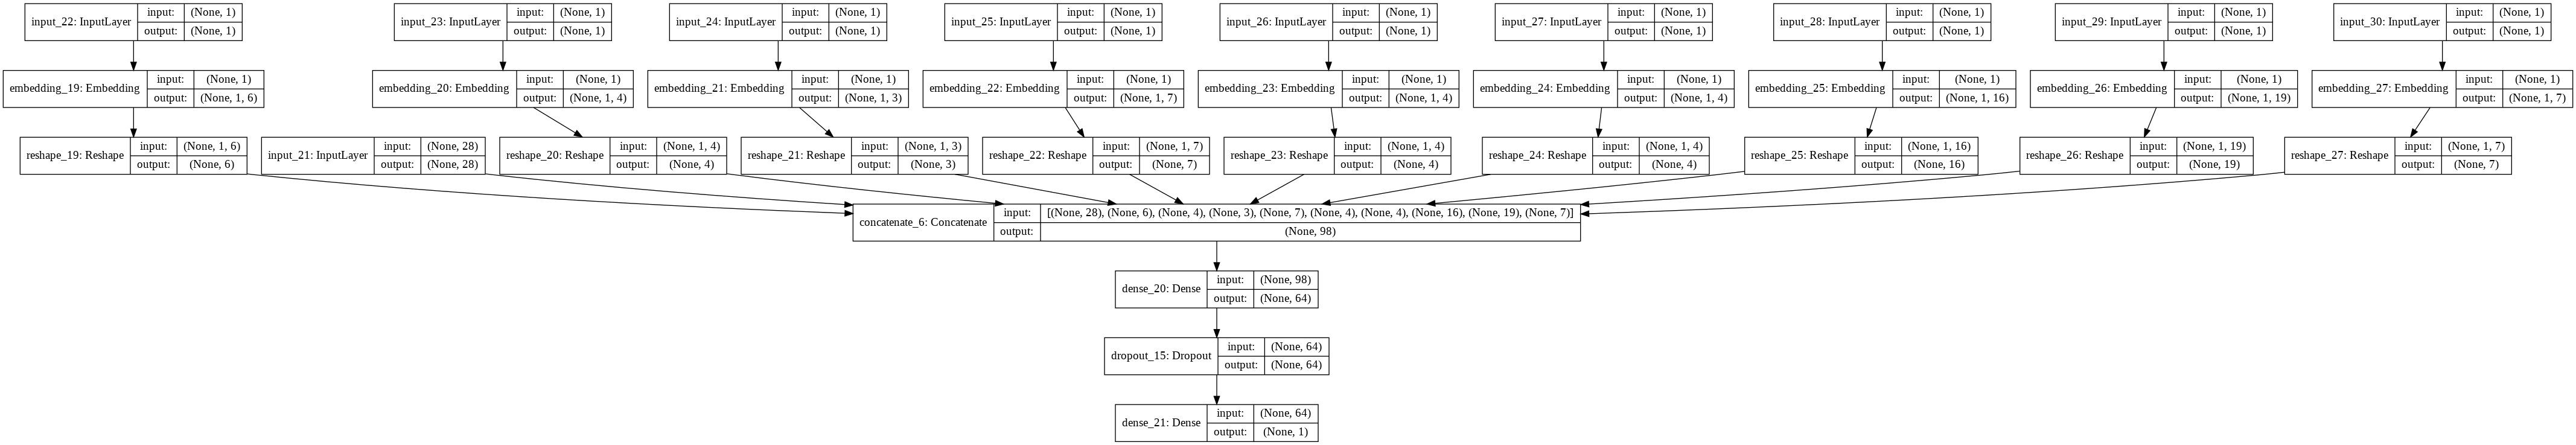

In [196]:
from keras.utils import plot_model
#https://datascience.stackexchange.com/questions/26103/merging-two-different-models-in-keras Mergin Models

prova= Embedded_prova()
plot_model(prova, show_shapes=True)

In [0]:
def summary_reg_model(model, X_train, X_test, task= 'usage', return_diz= False):
    
    pred_train= model.predict(X_train)
    pred_test= model.predict(X_test)
    if task== 'life':
      pred_train= pd.DataFrame(pred_train[0], index= np.arange(len(X_train[0]))).squeeze()
      pred_test= pd.DataFrame(pred_test[0], index= np.arange(len(X_test[0]))).squeeze()
      y_train= ytrain_life
      y_test= ytest_life
    elif task== 'usage':
      pred_train= pd.DataFrame(pred_train[1], index= np.arange(len(X_train[0]))).squeeze()
      pred_test= pd.DataFrame(pred_test[0], index= np.arange(len(X_test[0]))).squeeze()
      y_train= ytrain_usage
      y_test= ytest_usage

    diz={}
    diz['Train MAE']= round(100*mean_absolute_error(y_train, pred_train),3)
    diz['Test MAE'] =  round(100*mean_absolute_error(y_test, pred_test),3)
    diz['Train RMSE']= round(100*np.sqrt(mean_squared_error(y_train, pred_train)),3)
    diz['Test RMSE']=  round(100*np.sqrt(mean_squared_error(y_test, pred_test)),3)

    diz['Train MAPE']= round(MAPE((y_train, pred_train),3))
    diz['Test MAPE'] =  round(MAPE(y_test, pred_test),3)
    
    print('\t FOR OUTPUT \033[1m {} \033[0m, PERFORMANCES ARE: '.format(task.upper()))
    print('\n\033[1mtrain MAE is {} \033[0m'.format(diz['Train MAE']))
    print('\033[1mtest MAE is {} \033[0m'.format(diz['Test MAE']))
    
    print('\n\033[1mtrain RMSE is {} \033[0m'.format(diz['Train RMSE']))
    print('\033[1mtest RMSE is {} \033[0m'.format(diz['Test RMSE']))

    if task=='life':
      print('\n\033[1mtrain MAPE is {} \033[0m'.format(diz['Train MAPE']))
      print('\033[1mtest MAPE is {} \033[0m'.format(diz['Test MAPE']))

    if task=='usage':
      print('NB: MAPE sarà inf perchè viene diviso errore per il target e questo spesso è zero')

    if return_diz== True:
      return diz

### Defining Functions to build NN

In [0]:
from sklearn.model_selection import ParameterGrid
###### Naming Convention #######

all_inputs= concat_inputs_emb  
true_inputs= true_inputs_emb
with_dropout=True

In [0]:
nodi_hiddens= [64,32,16,8]
#with_dropout=True , 
dropout= 0.5
lr= 0.00001
n_layers= 1
loss_weights={'output_life': 1.0, 'output_usage': 1.0}

epochs= 50
batch_size= 128

def Double_Dense(all_inputs= concat_inputs_emb , true_inputs= true_inputs_emb, nodi_hiddens= nodi_hiddens, dropout= dropout, lr= lr, n_layers= n_layers, loss_func= 'mean_squared_error', metrics= ['mae'],
        loss_weights= loss_weights):

  #diz_pre_model= create_embedded_inputs(X_train, X_test, max_emb_size=50, method= 'half')
  print('\n\033[1m Params modello: n_layers: {}, nodi_hiddens: {}, lr: {} \033[0m'.format(n_layers, nodi_hiddens, lr))

  for i in range (n_layers):
    if i==0:
      if n_layers== 1:   #SUPER IMPORTANTE: CON 1 SOLO HIDDEN LAYER DEVO METTERE FALSE, SENNO NON GLI TORNANO LE SHAPES....
        gru1 = Dense(nodi_hiddens[0],  activation= 'relu')(all_inputs)
        drop= Dropout(dropout)(gru1)
      elif n_layers>1:
        gru1 = Dense(nodi_hiddens[0], activation= 'relu')(all_inputs)
        drop= Dropout(dropout)(gru1)
    else:
      gru = Dense(nodi_hiddens[i], activation= 'relu')(drop)
      drop= Dropout(dropout)(gru)

  output_life = Dense(1, activation= 'sigmoid', name='output_life')(drop)
  output_usage= Dense(1, activation= 'sigmoid', name='output_usage')(drop)
  model = Model(inputs= true_inputs, outputs=[output_life, output_usage])

  model.compile(optimizer= optimizers.Adam(lr= lr, ),
              loss={'output_life': 'mean_squared_error', 'output_usage': 'mean_squared_error'},
              loss_weights= loss_weights,  metrics= metrics)

  return model

In [204]:
prova= Double_Dense(n_layers=2)
prova.summary()


 Params modello: n_layers: 2, nodi_hiddens: [64, 32, 16, 8], lr: 1e-05 
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           (None, 1)            0                                            
__________________

In [205]:
prova.fit(final_X_train_emb, {"output_life": ytrain_life, "output_usage": ytrain_usage},
                  validation_split= 0.2,
                  epochs= 5,
                  verbose=2, batch_size= 64)

Train on 207242 samples, validate on 51811 samples
Epoch 1/5
 - 24s - loss: 0.4085 - output_life_loss: 0.1541 - output_usage_loss: 0.2545 - output_life_mean_absolute_error: 0.2952 - output_usage_mean_absolute_error: 0.4350 - val_loss: 0.2494 - val_output_life_loss: 0.0747 - val_output_usage_loss: 0.1747 - val_output_life_mean_absolute_error: 0.2097 - val_output_usage_mean_absolute_error: 0.3790
Epoch 2/5
 - 22s - loss: 0.2533 - output_life_loss: 0.0589 - output_usage_loss: 0.1945 - output_life_mean_absolute_error: 0.1622 - output_usage_mean_absolute_error: 0.3703 - val_loss: 0.2147 - val_output_life_loss: 0.0661 - val_output_usage_loss: 0.1486 - val_output_life_mean_absolute_error: 0.1688 - val_output_usage_mean_absolute_error: 0.3372
Epoch 3/5
 - 22s - loss: 0.2108 - output_life_loss: 0.0415 - output_usage_loss: 0.1693 - output_life_mean_absolute_error: 0.1245 - output_usage_mean_absolute_error: 0.3401 - val_loss: 0.2064 - val_output_life_loss: 0.0658 - val_output_usage_loss: 0.1406 -

In [206]:
preds_life= prova.predict(final_X_test_emb)[0]

index= np.arange(len(container_double['X_test']))
preds_life= pd.DataFrame(preds_life,  index= index ).squeeze()
ytest_life= pd.DataFrame(ytest_life).set_index(index).squeeze()

preds_life.head()

0    0.992004
1    0.989644
2    0.997670
3    1.000000
4    1.000000
Name: 0, dtype: float32

Text(0.5, 1, 'PLOT PER TASK % life')

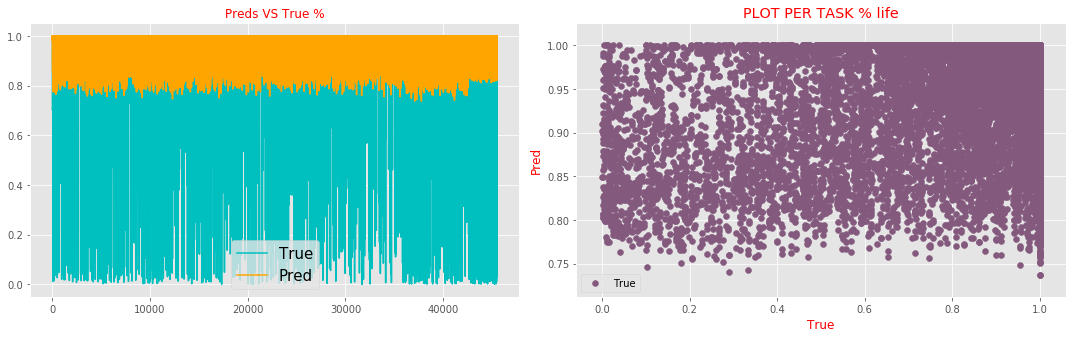

In [207]:
plot_preds_true(ytest_life , preds_life, single_model= True, plot_only_reg= False, n_to_show= 1000000, diz_models= None, n_cols= 2)
plt.title('PLOT PER TASK % {}'.format('life'))

In [0]:
def summary_reg_model(model, X_train, X_test, task= 'usage', return_diz= False):
    
    pred_train= model.predict(X_train)
    pred_test= model.predict(X_test)
    if task== 'life':
      pred_train= pd.DataFrame(pred_train[0], index= np.arange(len(X_train[0]))).squeeze()
      pred_test= pd.DataFrame(pred_test[0], index= np.arange(len(X_test[0]))).squeeze()
      y_train= ytrain_life
      y_test= ytest_life
    elif task== 'usage':
      pred_train= pd.DataFrame(pred_train[1], index= np.arange(len(X_train[0]))).squeeze()
      pred_test= pd.DataFrame(pred_test[0], index= np.arange(len(X_test[0]))).squeeze()
      y_train= ytrain_usage
      y_test= ytest_usage

    diz={}
    diz['Train MAE']= round(100*mean_absolute_error(y_train, pred_train),3)
    diz['Test MAE'] =  round(100*mean_absolute_error(y_test, pred_test),3)
    diz['Train RMSE']= round(100*np.sqrt(mean_squared_error(y_train, pred_train)),3)
    diz['Test RMSE']=  round(100*np.sqrt(mean_squared_error(y_test, pred_test)),3)

    diz['Train MAPE']= round(MAPE((y_train, pred_train),3))
    diz['Test MAPE'] =  round(MAPE(y_test, pred_test),3)
    
    print('\t FOR OUTPUT \033[1m {} \033[0m, PERFORMANCES ARE: '.format(task.upper()))
    print('\n\033[1mtrain MAE is {} \033[0m'.format(diz['Train MAE']))
    print('\033[1mtest MAE is {} \033[0m'.format(diz['Test MAE']))
    
    print('\n\033[1mtrain RMSE is {} \033[0m'.format(diz['Train RMSE']))
    print('\033[1mtest RMSE is {} \033[0m'.format(diz['Test RMSE']))

    if task=='life':
      print('\n\033[1mtrain MAPE is {} \033[0m'.format(diz['Train MAPE']))
      print('\033[1mtest MAPE is {} \033[0m'.format(diz['Test MAPE']))

    if task=='usage':
      print('NB: MAPE sarà inf perchè viene diviso errore per il target e questo spesso è zero')

    if return_diz== True:
      return diz

In [0]:
def run_model_RNN(model, param_grid= None, verbose=5, cv=3, n_jobs= None, return_single_mod= True, return_results=True, n_to_show= 1000, summary= True,
              early= None, measures = ["output_usage_mean_absolute_error", "output_life_mean_absolute_error", "loss"], batch_size= 64, epochs= 50, random=False): 
    """estimator è il modello, task puo essere: ['reg', 'reg']. \n
    Return Grid Search estimator. """
    
      #Naming Convention
    X_train= final_inputs_train= final_X_train_emb
    X_test= final_inputs_test= final_X_test_emb 
    
    temp=time.time()
      
    if param_grid is None:
      history= model.fit(X_train,
                  {"output_life": ytrain_life, "output_usage": ytrain_usage},
                  validation_split= 0.2,
                  epochs=epochs,
                  verbose=2, batch_size= batch_size, callbacks= [early])
        
    summaries= {}
    for task in ['usage', 'life']:
        summaries[task]= summary_reg_model(model, X_train, X_test, task= task, return_diz= True)

        pred_train= model.predict(X_train)
        pred_test= model.predict(X_test)
        if task== 'life':
          pred_train= pd.DataFrame(pred_train[0], index= np.arange(len(X_train[0]))).squeeze()
          pred_test= pd.DataFrame(pred_test[0], index= np.arange(len(X_test[0]))).squeeze()
          y_train= ytrain_life
          y_test= ytest_life
        elif task== 'usage':
          pred_train= pd.DataFrame(pred_train[1], index= np.arange(len(X_train[0]))).squeeze()
          pred_test= pd.DataFrame(pred_test[0], index= np.arange(len(X_test[0]))).squeeze()
          y_train= ytrain_usage
          y_test= ytest_usage

        plot_preds_true(y_test, pred_test, single_model= True, plot_only_reg= False, n_to_show= n_to_show, diz_models= None, n_cols= 2, task= task)

    plot_model_history(history, measures= measures)
      
    print('execution time (min)=', round((time.time()-temp)/60, 1), ' finished at ', datetime.today())

    return [history, summaries]

**Iterative grid search of NN with embedded categories**


	 ITERAZIONE 1/1

 n_layers: 2, batch_size: 128, dropout: 0.5, lr: 0.001 
 nodi_hidden1 : 64 
 nodi_hidden2 : 64 

 Params modello: n_layers: 2, nodi_hiddens: [64, 64, 16, 8], lr: 0.001 
Train on 207242 samples, validate on 51811 samples
Epoch 1/30
 - 13s - loss: 0.1264 - output_life_loss: 0.0282 - output_usage_loss: 0.0983 - output_life_mean_absolute_error: 0.0873 - output_usage_mean_absolute_error: 0.2441 - val_loss: 0.1633 - val_output_life_loss: 0.0507 - val_output_usage_loss: 0.1126 - val_output_life_mean_absolute_error: 0.1288 - val_output_usage_mean_absolute_error: 0.2719
Epoch 2/30
 - 11s - loss: 0.0957 - output_life_loss: 0.0238 - output_usage_loss: 0.0719 - output_life_mean_absolute_error: 0.0801 - output_usage_mean_absolute_error: 0.2030 - val_loss: 0.1603 - val_output_life_loss: 0.0502 - val_output_usage_loss: 0.1101 - val_output_life_mean_absolute_error: 0.1307 - val_output_usage_mean_absolute_error: 0.2650
Epoch 3/30
 - 11s - loss: 0.0914 - output_life_loss: 0.0221 - out

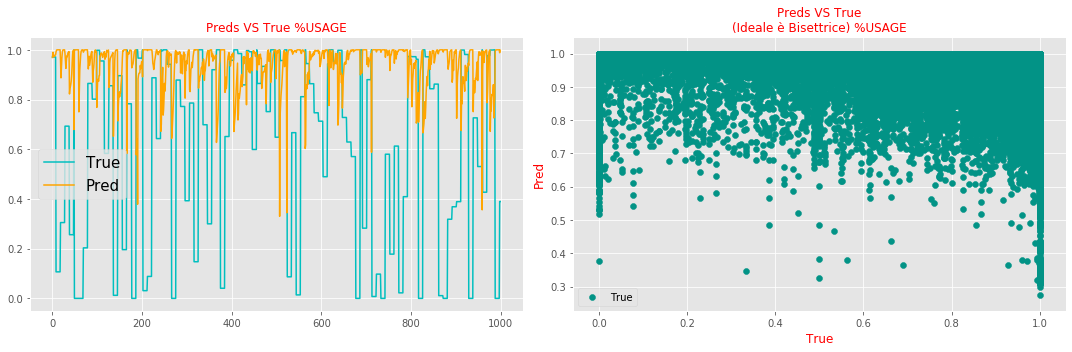

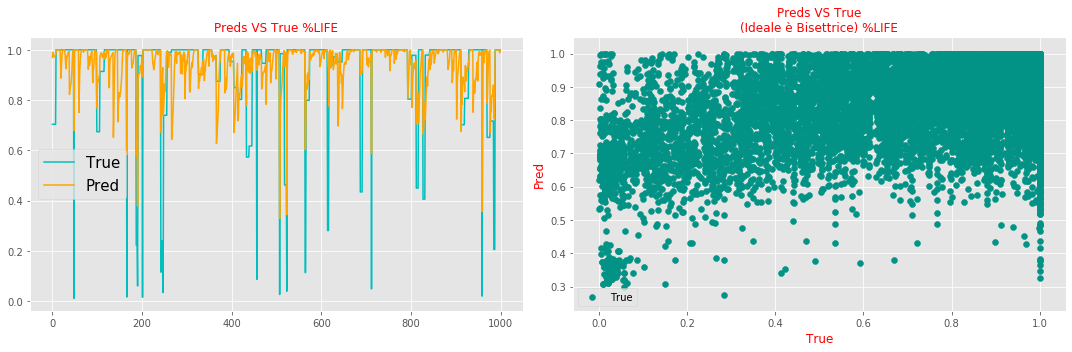

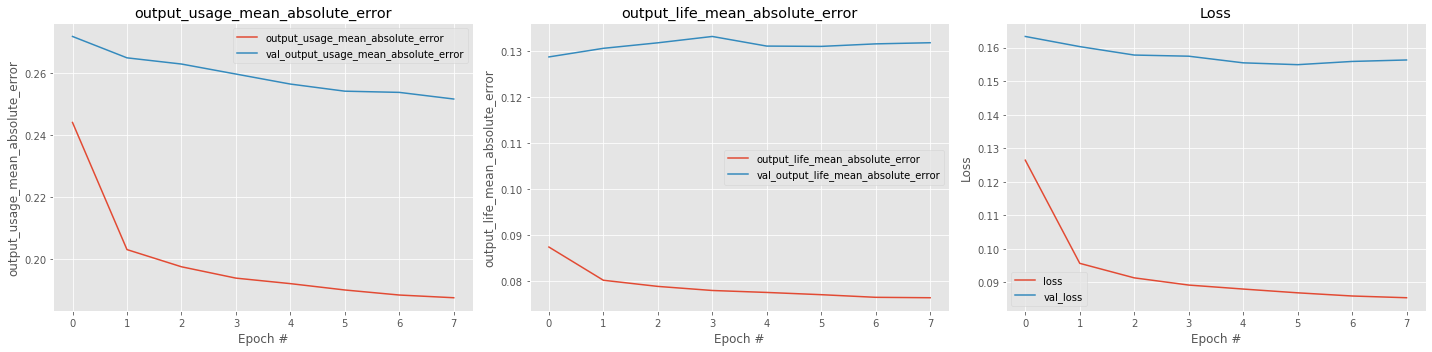

execution time (min)= 2.6  finished at  2019-11-13 23:54:42.270039


In [251]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=4, patience=5, min_delta= 0.5/100) #

param_grid = dict(
        n_layers= [2],
        nodi_hiddens=  [[64,64,16,8]],  #[256,128,32,8]],
        epochs= [30],
        batch_size= [128],
        dropout= [0.5] ,
        lr= [1e-03],
        loss_weights= [{'output_life': 1.0, 'output_usage': 1.0}])

l=[]
iteration=1

for diz in list(ParameterGrid(param_grid)):
  print('\n\t ITERAZIONE {}/{}'.format(iteration, len(list(ParameterGrid(param_grid)))))
  n_layers= diz['n_layers']
  nodi_hiddens= diz['nodi_hiddens']
  batch_size= diz['batch_size']
  dropout= diz['dropout']
  epochs= diz['epochs']
  lr= diz['lr']
  print('\n\033[1m n_layers: {}, batch_size: {}, dropout: {}, lr: {} \033[0m'.format(n_layers, batch_size, dropout, lr))
  for i in range(n_layers):
      print('\033[1m nodi_hidden{} : {} \033[0m'.format(str(i+1), str(nodi_hiddens[i]) ))
  
  #nn = KerasRegressor(build_fn= NN, epochs=epochs, batch_size=batch_size, verbose=2)
  nn= Double_Dense(nodi_hiddens= nodi_hiddens, dropout= dropout, lr= lr, n_layers= n_layers,
                loss_weights= loss_weights, metrics= ['mae'])
  
  history_one= run_model_RNN(nn, early= early, batch_size= batch_size, epochs= epochs)

  l.append(history_one)
  iteration+=1

### Automated analysis of the error: Finding best model of the Grid Search, seeing prediction error in respect to Nominal Duration and check which contracts have both cosumption and %life low, which are the contraddictory cases.**

In [252]:
l

[[<keras.callbacks.History at 0x7f0e9f9c3a58>,
  {'life': {'Test MAE': 8.476,
    'Test MAPE': inf,
    'Test RMSE': 16.17,
    'Train MAE': 8.257,
    'Train MAPE': inf,
    'Train RMSE': 15.874},
   'usage': {'Test MAE': 42.372,
    'Test MAPE': inf,
    'Test RMSE': 55.198,
    'Train MAE': 19.429,
    'Train MAPE': inf,
    'Train RMSE': 26.247}}]]

In [0]:
def results_hand_grid( lista_histories= l, param_grid= param_grid, columns= ['n_layers', 'nodi_hiddens','batch_size', 'dropout', 'Train MAE', 'Test MAE', 'Train RMSE', 'Test RMSE'],
                      task= 'life'):

  iteraz=0
  
  results_emb_1h= pd.DataFrame(columns= columns )

  for diz in list(ParameterGrid(param_grid)):
    res= lista_histories[iteraz][1][task]

    df= pd.DataFrame([
    diz['n_layers'],
    diz['nodi_hiddens'],
    diz['batch_size'],
    diz['dropout'],
    res['Train MAE'],
    res['Test MAE'],
    res['Train RMSE'],
    res['Test RMSE']    ]).T

    df.columns= columns
    
    #print(df)
    results_emb_1h= results_emb_1h.append(df, ignore_index=True)

    iteraz+=1
  return results_emb_1h.sort_values(by= 'Test MAE', ascending= False)

In [254]:
columns= ['n_layers', 'nodi_hiddens','batch_size', 'dropout', 'Train MAE', 'Test MAE', 'Train RMSE', 'Test RMSE']
results_hand_grid( lista_histories= l, param_grid= param_grid, columns= columns, task= 'life')

,n_layers,nodi_hiddens,batch_size,dropout,Train MAE,Test MAE,Train RMSE,Test RMSE
0,2,"[64, 64, 16, 8]",128,0.5,8.257,8.476,15.874,16.17


In [255]:
columns= ['n_layers', 'nodi_hiddens','batch_size', 'dropout', 'Train MAE', 'Test MAE', 'Train RMSE', 'Test RMSE']
results_hand_grid( lista_histories= l, param_grid= param_grid, columns= columns, task= 'usage')

,n_layers,nodi_hiddens,batch_size,dropout,Train MAE,Test MAE,Train RMSE,Test RMSE
0,2,"[64, 64, 16, 8]",128,0.5,19.429,42.372,26.247,55.198


In [256]:
l[0][0].model.predict(final_X_test_emb)[0][:5]

array([[0.9693047 ],
       [0.9904109 ],
       [0.97644603],
       [0.9726212 ],
       [0.9728855 ]], dtype=float32)

In [0]:
def analisi_errore_reg( best_respect_to= 'life', return_df_grids= True,
                       columns= ['n_layers', 'nodi_hiddens','batch_size', 'dropout', 'Train MAE', 'Test MAE', 'Train RMSE', 'Test RMSE'], n_to_show= 3,
                       measures = ["output_usage_mean_absolute_error", "output_life_mean_absolute_error", "loss"], X_test=final_X_test_emb ,lista_histories= l,):
  
  models= []
  for task in ['life', 'usage']:
    models.append(results_hand_grid( lista_histories= l, param_grid= param_grid, columns= columns, task= task))

  if best_respect_to== 'life':
    #print('Best index: ', models[0].index[0])
    best_history=lista_histories[ models[0].index[0]][0]
  elif best_respect_to== 'usage':
    best_history= lista_histories[ models[1].index[0]][0]

  ############### Metrics e Loss###################
  plot_model_history(best_history, measures= measures)

  best_model= best_history.model
  preds= best_model.predict(X_test )  
  preds_life, preds_usage= pd.DataFrame(preds[0]).squeeze(), pd.DataFrame(preds[1]).squeeze()

  ############### plot 'Time Series' e Bisettrice###################
  for task in ['life', 'usage']:
    if task== 'life':
      ytest= ytest_life
      preds= preds_life
    elif task== 'usage':
      ytest= ytest_usage
      preds= preds_usage
    plot_preds_true( ytest, preds, task='life', plot_only_reg= False)

  ############# Contradditori ####################
  contraddittori= pd.DataFrame()
  contraddittori['preds_life']= preds_life
  contraddittori['preds_usage']= preds_usage

  len_test= container_reg['X_test'].shape[0]
  contraddittori= contraddittori[(contraddittori['preds_life']< 1) & (contraddittori['preds_usage']< 0.9 )]
  perc_contraddittori= round(100*contraddittori.shape[0]/len_test, 2)
  title_ticks_ecc('PREDETTI NON UTILIZZATI MA VITA INFERIORE. \n Sono il {} % dei casi sul test :(((' .format(perc_contraddittori), 'Pred Utilizzo', 'Pred Life')
  sns.scatterplot(x= contraddittori['preds_usage'], y= contraddittori['preds_life'])
  plt.xticks(np.arange(0, 1.01, 0.3))


  ############# Errore rispetto a durata nominale #########################
  delta_preds_life = pd.DataFrame()
  delta_preds_life['durata_nominale_gg']= container_reg['X_test']['durata_nominale_gg']
  delta_preds_life['True_life']= ytest_life.values
  delta_preds_life['preds_life']= preds_life.values

  delta_preds_life['delta errore %']= abs(delta_preds_life['True_life']- delta_preds_life['preds_life'])

  title_ticks_ecc('DURATA NOMINALE VS DELTA ERRORE % VITA', 'Durata Nominale', 'Pred % Life')
  sns.scatterplot(delta_preds_life['durata_nominale_gg'], delta_preds_life['delta errore %'])



  if return_df_grids is True:
    return models

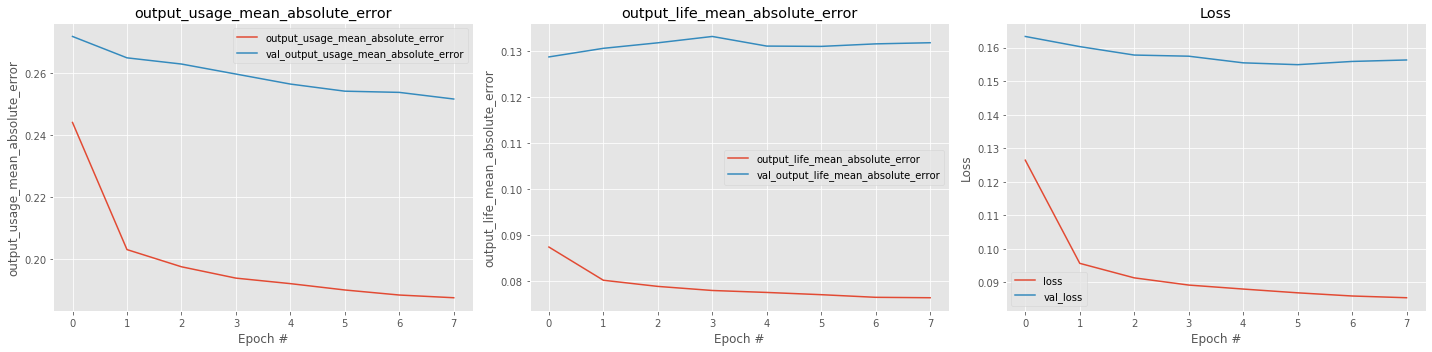

[  n_layers     nodi_hiddens batch_size dropout Train MAE Test MAE Train RMSE  \
 0        2  [64, 64, 16, 8]        128     0.5     8.257    8.476     15.874   
 
   Test RMSE  
 0     16.17  ,
   n_layers     nodi_hiddens batch_size dropout Train MAE Test MAE Train RMSE  \
 0        2  [64, 64, 16, 8]        128     0.5    19.429   42.372     26.247   
 
   Test RMSE  
 0    55.198  ]

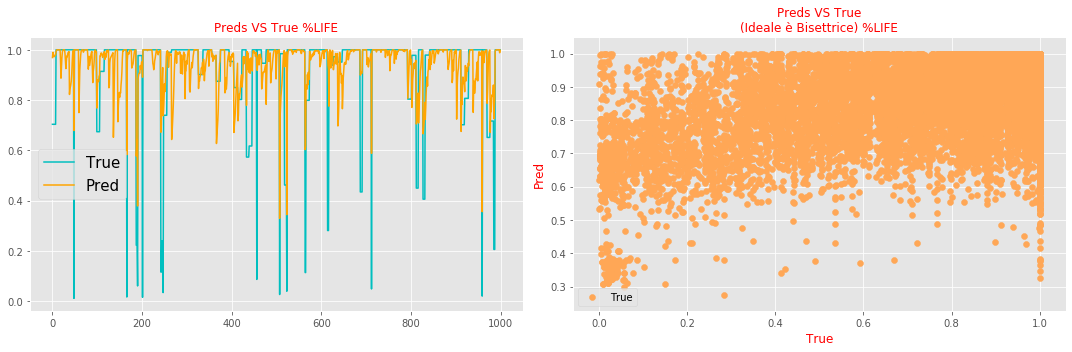

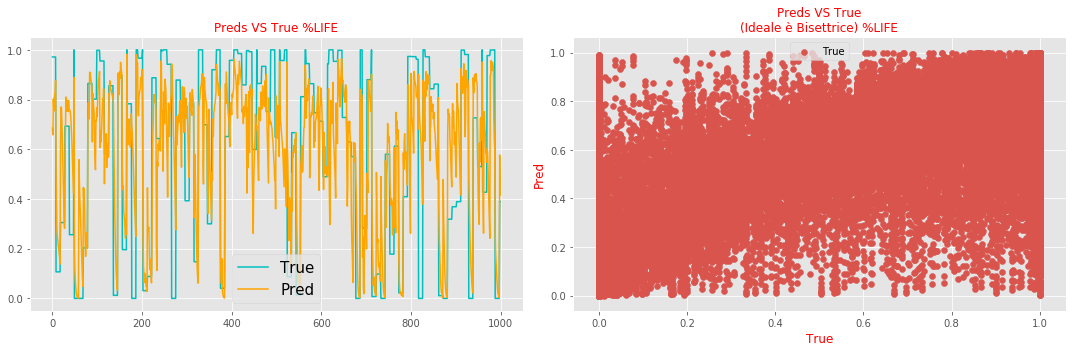

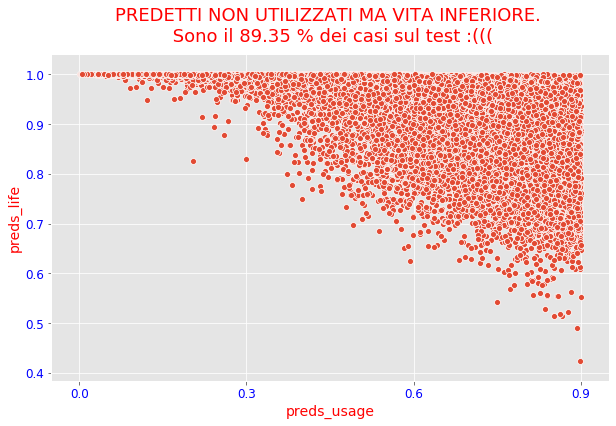

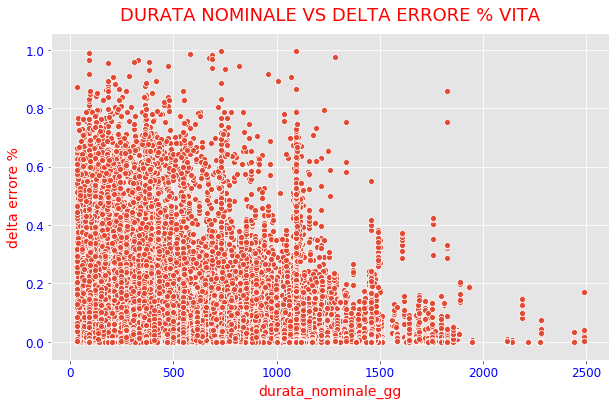

In [258]:
analisi_errore_reg()